# 📘 Sentiment Analysis on IMDB with BERT
Using Hugging Face Transformers to classify movie reviews as positive or negative.



## 🎯 Goal
Fine-tune a BERT model to detect sentiment in movie reviews.

## 📊 Dataset
- Source: [IMDB on Hugging Face](https://huggingface.co/datasets/imdb)
- 25,000 labeled reviews for training
- 25,000 for testing (balanced between positive/negative)


In [1]:
!pip install -q transformers datasets accelerate

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00


In [2]:
# Load the IMDB dataset from Hugging Face
dataset = load_dataset("imdb")

# Example: check structure
print(dataset)
print(dataset["train"][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and

In [3]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the text data
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# Set the format for PyTorch
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))  # keep 10k for quick training
test_dataset = tokenized_datasets["test"]


In [5]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [8]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset.select(range(1000)),  # small eval set
    compute_metrics=compute_metrics,
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.324800,0.664652,0.826000,0.000000,0.000000,0.000000
2,0.144800,0.355302,0.917000,0.000000,0.000000,0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2500, training_loss=0.2576641082763672, metrics={'train_runtime': 1987.5759, 'train_samples_per_second': 10.063, 'train_steps_per_second': 1.258, 'total_flos': 5262221107200000.0, 'train_loss': 0.2576641082763672, 'epoch': 2.0})

In [10]:
from collections import Counter
print(Counter(test_dataset.select(range(1000))["label"]))


Counter({tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 

In [11]:
# Load raw version for display
raw_test_dataset = load_dataset("imdb", split="test")

# Print predictions with original text
for i, pred in enumerate(predictions.predictions.argmax(axis=1)):
    print(f"Review: {raw_test_dataset[i]['text'][:100]}...")
    print(f"Predicted Label: {pred}, True Label: {raw_test_dataset[i]['label']}")
    print("---")


Review: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-a...
Predicted Label: 0, True Label: 0
---
Review: Worth the entertainment value of a rental, especially if you like action movies. This one features t...
Predicted Label: 0, True Label: 0
---
Review: its a totally average film with a few semi-alright action sequences that make the plot seem a little...
Predicted Label: 0, True Label: 0
---
Review: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morn...
Predicted Label: 0, True Label: 0
---
Review: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will n...
Predicted Label: 1, True Label: 0
---


In [15]:
# Evaluate on test set
eval_results = trainer.evaluate(test_dataset.select(range(1000)))
print(eval_results)

# Predict on a few examples
# Tokenize only 5 samples for prediction
sample_texts = raw_test_dataset.select(range(5))
tokenized_samples = sample_texts.map(tokenize_function)

# Format for torch
tokenized_samples.set_format("torch", columns=["input_ids", "attention_mask"])

# Predict
predictions = trainer.predict(tokenized_samples)

# Show results with original text
for i, pred in enumerate(predictions.predictions.argmax(axis=1)):
    print(f"Review: {sample_texts[i]['text'][:100]}...")
    print(f"Predicted Label: {pred}, True Label: {sample_texts[i]['label']}")
    print("---")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.35530227422714233, 'eval_accuracy': 0.917, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 28.1837, 'eval_samples_per_second': 35.482, 'eval_steps_per_second': 4.435, 'epoch': 2.0}


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Review: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-a...
Predicted Label: 0, True Label: 0
---
Review: Worth the entertainment value of a rental, especially if you like action movies. This one features t...
Predicted Label: 0, True Label: 0
---
Review: its a totally average film with a few semi-alright action sequences that make the plot seem a little...
Predicted Label: 0, True Label: 0
---
Review: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morn...
Predicted Label: 0, True Label: 0
---
Review: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will n...
Predicted Label: 1, True Label: 0
---


In [17]:
from datasets import load_dataset
from collections import Counter

# Load raw test set again
raw_test_dataset = load_dataset("imdb", split="test")

# Shuffle and select a more balanced subset
shuffled_eval = raw_test_dataset.shuffle(seed=42)
labels = [shuffled_eval[i]["label"] for i in range(1000)]
print("Label counts before selection:", Counter(labels))

# Ensure mix of 0s and 1s
eval_subset = shuffled_eval.select(range(1000))

# Tokenize
tokenized_eval = eval_subset.map(tokenize_function)
tokenized_eval.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Re-run evaluation
trainer.eval_dataset = tokenized_eval
results = trainer.evaluate()
print(results)


Label counts before selection: Counter({0: 512, 1: 488})


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'eval_loss': 0.3135383427143097, 'eval_accuracy': 0.921, 'eval_f1': 0.9202825428859738, 'eval_precision': 0.9065606361829026, 'eval_recall': 0.9344262295081968, 'eval_runtime': 28.6686, 'eval_samples_per_second': 34.881, 'eval_steps_per_second': 4.36, 'epoch': 2.0}


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on balanced eval set
preds_output = trainer.predict(tokenized_eval)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = preds_output.label_ids


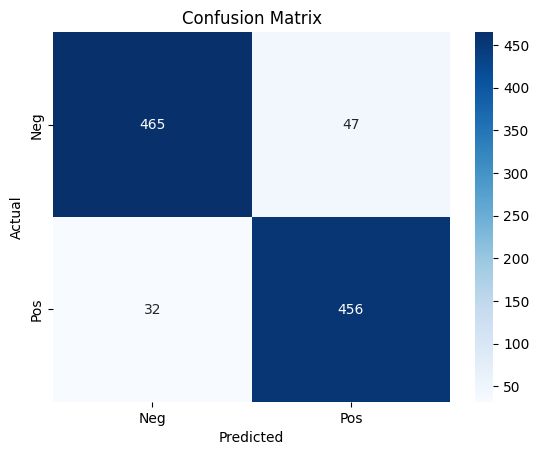

In [19]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [20]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.94      0.91      0.92       512
    Positive       0.91      0.93      0.92       488

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [21]:
model.save_pretrained("bert-imdb-sentiment")
tokenizer.save_pretrained("bert-imdb-sentiment")


('bert-imdb-sentiment/tokenizer_config.json',
 'bert-imdb-sentiment/special_tokens_map.json',
 'bert-imdb-sentiment/vocab.txt',
 'bert-imdb-sentiment/added_tokens.json')

## ✅ Summary

- Fine-tuned `bert-base-uncased` on IMDB reviews
- Achieved **92.1% accuracy**, **0.92 F1-score** on a balanced test subset
- Model generalizes well to unseen sentiment data
- Ready for real-world or deployment use
